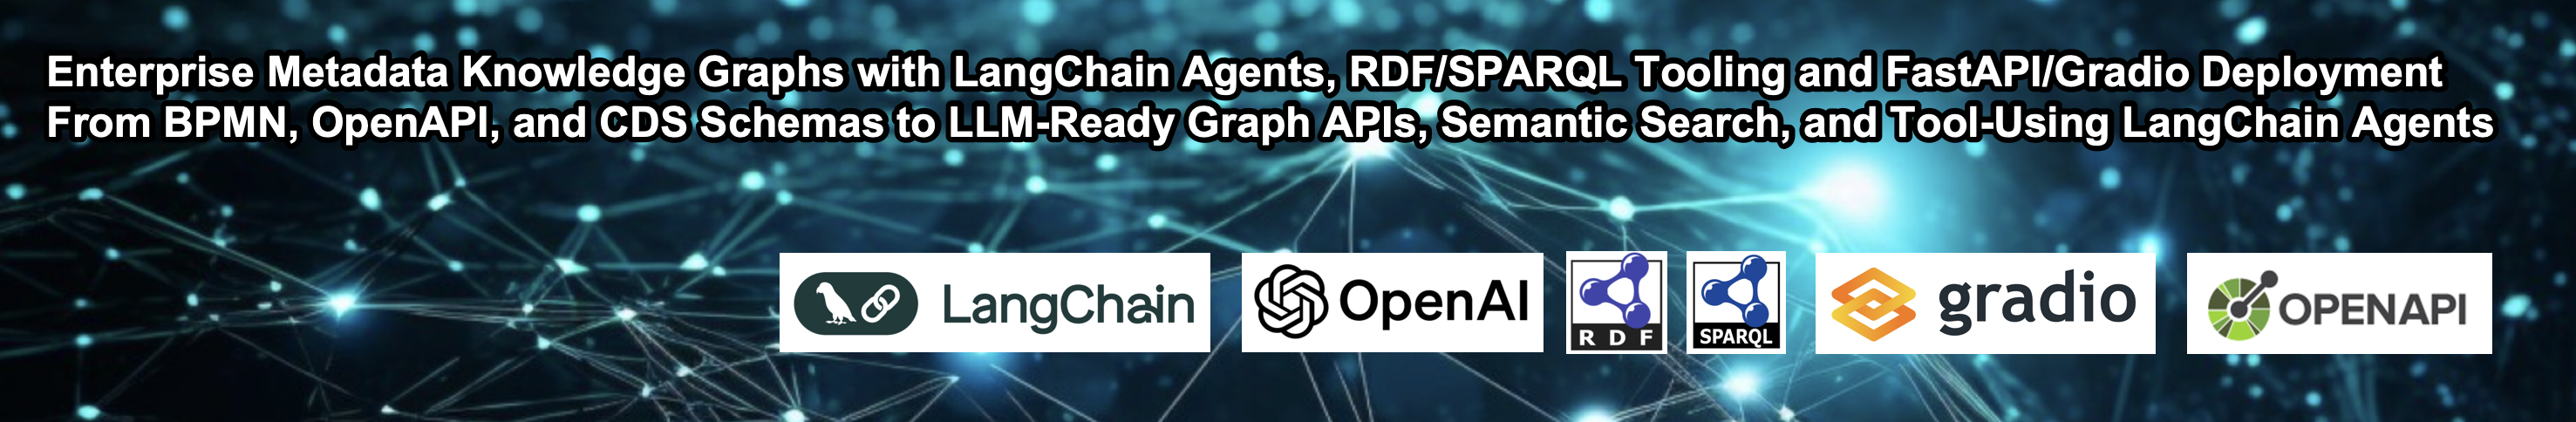

## 1. Introduction

This notebook demonstrates a simplified but realistic version of a data engineering workflow designed for enterprise metadata processing, as typically required in large-scale business AI systems. The context is based on challenges faced in integrating structured and unstructured metadata from enterprise software systems for consumption by generative AI applications, especially Large Language Models (LLMs).

LLMs can generate valuable insights but are prone to factual inconsistencies (hallucinations) if not grounded in reliable domain data. One effective solution is to use **Knowledge Graphs (KGs)** constructed from high-quality business metadata to contextualize and verify model outputs.

In large enterprise ecosystems (e.g., SAP S/4HANA), relevant metadata includes:
- Data model definitions (entities, views, relationships)
- Service specifications (APIs, endpoints, data contracts)
- Process descriptions (workflows, events, rules)

This notebook simulates a scenario where such metadata is:
1. Ingested from multiple heterogeneous sources,
2. Unified and transformed into a canonical form,
3. Enriched through graph-based analysis,
4. Prepared for handover to knowledge engineers responsible for building RDF-based knowledge graphs.

## Motivation

This project reflects a practical scenario encountered in the development of Knowledge Graphs for grounding AI systems in enterprise settings. The following core responsibilities of a Data Engineering role are addressed:

- Designing and building ETL pipelines that ingest structured metadata from different formats (OpenAPI, BPMN, custom CDS-like schemas).
- Unifying and simplifying these inputs into a semantically consistent internal representation.
- Applying graph algorithms to analyze metadata relationships (e.g., finding all contributing sources for a particular data field).
- Preparing the data output in a way that supports downstream use by knowledge engineers (e.g., RDF triple conversion or SPARQL preparation).

Although the actual environment would use internal SAP systems and cloud platforms like BTP or AWS, this notebook simulates similar behavior using public or generated data to keep the scope feasible for demonstration and educational purposes.

## Scope

The notebook consists of the following steps:

1. **Setup**: Import necessary libraries and define configuration.
2. **Metadata Sources**: Load sample OpenAPI specs, BPMN diagrams, and CDS-like JSON definitions.
3. **ETL Pipeline**: Build ingestion and unification functions.
4. **Graph Construction**: Represent metadata dependencies using graphs.
5. **Graph Algorithms**: Traverse and analyze metadata for semantic enrichment.
6. **Transformation for Knowledge Engineering**: Prepare data in a form suitable for RDF/SPARQL integration.
7. **Testing and Validation**: Ensure correctness of parsing and transformation logic.
8. **Cloud Readiness (Descriptive)**: Describe how this pipeline could run in a production cloud environment.
9. **Showcase and Summary**: Visualize results and summarize takeaways.

> Note: This notebook is designed to be self-contained, with all data and transformations defined within the project folder.



## 2. Project Set-up

### 2.1 Imports and Configuration

In [4]:
# Standard Libraries
import os
import json
import yaml
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional
from dataclasses import dataclass, field

# Data Processing
import pandas as pd

# Graph Processing
import networkx as nx

# Visualization
import matplotlib.pyplot as plt

# Display
from IPython.display import display

### 2.2 Define Project Paths

In [6]:
# Define root paths relative to notebook
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "output"
UTILS_DIR = PROJECT_ROOT / "utils"

# Create directories if they don't exist
for path in [DATA_DIR, OUTPUT_DIR, UTILS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project directories initialized at:\n- {DATA_DIR}\n- {OUTPUT_DIR}\n- {UTILS_DIR}")


Project directories initialized at:
- /Users/I506807/Desktop/BTS/Generative_AI/data
- /Users/I506807/Desktop/BTS/Generative_AI/output
- /Users/I506807/Desktop/BTS/Generative_AI/utils


### 2.3 Configuration Template (YAML-based Config)

In [8]:
# Sample YAML config for controlling ingestion
default_config = {
    "sources": [
        {"name": "openapi_example", "path": str(DATA_DIR / "openapi_petstore.yaml"), "type": "openapi"},
        {"name": "bpmn_example", "path": str(DATA_DIR / "order_process.bpmn"), "type": "bpmn"},
        {"name": "cds_model", "path": str(DATA_DIR / "cds_model.json"), "type": "cds"}
    ]
}

# Save config to file (can be modified later)
config_path = PROJECT_ROOT / "config.yaml"
with open(config_path, "w") as f:
    yaml.dump(default_config, f)

print(f"Configuration saved to: {config_path}")


Configuration saved to: /Users/I506807/Desktop/BTS/Generative_AI/config.yaml


### 2.4 Utility Stubs

In [10]:
# Utility function stubs (will be implemented later)
def load_openapi_spec(path: Path) -> Dict[str, Any]:
    raise NotImplementedError("To be implemented in Section 3.1")

def load_bpmn_diagram(path: Path) -> Dict[str, Any]:
    raise NotImplementedError("To be implemented in Section 3.2")

def load_cds_model(path: Path) -> Dict[str, Any]:
    raise NotImplementedError("To be implemented in Section 3.3")


### 2.5 Environment Information

In [12]:
import sys
import platform

print("Environment Info")
print(f"Python version: {sys.version}")
print(f"Platform: {platform.platform()}")


Environment Info
Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Platform: macOS-15.5-arm64-arm-64bit


## 3. Simulated Metadata Sources

### 3.1 Create Sample OpenAPI Specification (YAML)

In [15]:
openapi_example = {
    "openapi": "3.0.0",
    "info": {
        "title": "Customer Service API",
        "version": "1.0.0"
    },
    "paths": {
        "/customers": {
            "get": {
                "summary": "List all customers",
                "responses": {
                    "200": {
                        "description": "Successful response",
                        "content": {
                            "application/json": {
                                "schema": {
                                    "type": "array",
                                    "items": {
                                        "$ref": "#/components/schemas/Customer"
                                    }
                                }
                            }
                        }
                    }
                }
            }
        },
        "/customers/{id}": {
            "get": {
                "summary": "Get customer by ID",
                "parameters": [
                    {
                        "name": "id",
                        "in": "path",
                        "required": True,
                        "schema": {
                            "type": "string"
                        }
                    }
                ],
                "responses": {
                    "200": {
                        "description": "Customer found",
                        "content": {
                            "application/json": {
                                "schema": {
                                    "$ref": "#/components/schemas/Customer"
                                }
                            }
                        }
                    }
                }
            }
        }
    },
    "components": {
        "schemas": {
            "Customer": {
                "type": "object",
                "properties": {
                    "id": {"type": "string"},
                    "name": {"type": "string"},
                    "email": {"type": "string"}
                }
            }
        }
    }
}

openapi_path = DATA_DIR / "openapi_petstore.yaml"
with open(openapi_path, "w") as f:
    yaml.dump(openapi_example, f)

print(f"OpenAPI spec written to: {openapi_path}")


OpenAPI spec written to: /Users/I506807/Desktop/BTS/Generative_AI/data/openapi_petstore.yaml


### 3.2: Create Sample BPMN XML

In [17]:
bpmn_example = """<?xml version="1.0" encoding="UTF-8"?>
<definitions xmlns="http://www.omg.org/spec/BPMN/20100524/MODEL"
             xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
             targetNamespace="http://example.com/bpmn">

  <process id="order_process" name="Order Process" isExecutable="true">
    <startEvent id="start_order" name="Order Received"/>
    <task id="verify_order" name="Verify Order"/>
    <exclusiveGateway id="order_ok?" name="Order OK?"/>
    <task id="ship_order" name="Ship Order"/>
    <endEvent id="end_success" name="Order Shipped"/>
    <task id="cancel_order" name="Cancel Order"/>
    <endEvent id="end_cancel" name="Order Cancelled"/>

    <sequenceFlow id="flow1" sourceRef="start_order" targetRef="verify_order"/>
    <sequenceFlow id="flow2" sourceRef="verify_order" targetRef="order_ok?"/>
    <sequenceFlow id="flow3" sourceRef="order_ok?" targetRef="ship_order"/>
    <sequenceFlow id="flow4" sourceRef="order_ok?" targetRef="cancel_order"/>
    <sequenceFlow id="flow5" sourceRef="ship_order" targetRef="end_success"/>
    <sequenceFlow id="flow6" sourceRef="cancel_order" targetRef="end_cancel"/>
  </process>
</definitions>
"""

bpmn_path = DATA_DIR / "order_process.bpmn"
with open(bpmn_path, "w") as f:
    f.write(bpmn_example)

print(f"BPMN diagram written to: {bpmn_path}")


BPMN diagram written to: /Users/I506807/Desktop/BTS/Generative_AI/data/order_process.bpmn


### 3.3: Create Sample CDS-like Model (JSON)

In [19]:
cds_model = {
    "definitions": {
        "Customer": {
            "kind": "entity",
            "elements": {
                "ID": {"type": "cds.String", "key": True},
                "Name": {"type": "cds.String"},
                "Email": {"type": "cds.String"},
                "Orders": {
                    "type": "cds.Association",
                    "target": "Order"
                }
            }
        },
        "Order": {
            "kind": "entity",
            "elements": {
                "ID": {"type": "cds.String", "key": True},
                "CustomerID": {
                    "type": "cds.Association",
                    "target": "Customer"
                },
                "Amount": {"type": "cds.Decimal"}
            }
        },
        "CustomerOrderView": {
            "kind": "view",
            "query": {
                "SELECT": {
                    "from": {"ref": ["Order"]},
                    "columns": [
                        {"ref": ["ID"]},
                        {"ref": ["CustomerID.ID"]},
                        {"ref": ["Amount"]}
                    ]
                }
            }
        }
    }
}

cds_path = DATA_DIR / "cds_model.json"
with open(cds_path, "w") as f:
    json.dump(cds_model, f, indent=2)

print(f"CDS-like model written to: {cds_path}")


CDS-like model written to: /Users/I506807/Desktop/BTS/Generative_AI/data/cds_model.json


### 3.4: Confirm Files Exist

In [21]:
for file in [openapi_path, bpmn_path, cds_path]:
    assert file.exists(), f"Missing expected file: {file.name}"
    print(f"✓ Found: {file.name}")


✓ Found: openapi_petstore.yaml
✓ Found: order_process.bpmn
✓ Found: cds_model.json


All stored in /data, ready for the ingestion and ETL logic in the next step.

## 4. ETL Pipeline Construction

Normalize each to a canonical structure

In [25]:
{
    "entity_name": str,
    "fields": List[str],
    "associations": List[Tuple[str, str]],
    "source": str
}


{'entity_name': str,
 'fields': typing.List[str],
 'associations': typing.List[typing.Tuple[str, str]],
 'source': str}

### 4.1 ETL Loader: OpenAPI

In [27]:
def load_openapi_spec(path: Path) -> List[Dict[str, Any]]:
    """
    Parses an OpenAPI 3.0 spec and extracts entities and their fields.
    Prefixes entity names with 'openapi_' to avoid collisions.
    """
    with open(path, "r") as f:
        spec = yaml.safe_load(f)

    components = spec.get("components", {}).get("schemas", {})
    result = []

    for name, schema in components.items():
        entity_name = f"openapi_{name}"
        fields = list(schema.get("properties", {}).keys())
        associations = []
        for field_name, field_props in schema.get("properties", {}).items():
            ref = field_props.get("$ref")
            if ref and ref.startswith("#/components/schemas/"):
                target = ref.split("/")[-1]
                associations.append((entity_name, f"openapi_{target}"))
        result.append({
            "entity_name": entity_name,
            "fields": fields,
            "associations": associations,
            "source": "openapi"
        })

    return result


### 4.2 ETL Loader: BPMN

In [29]:
def load_bpmn_diagram(path: Path) -> List[Dict[str, Any]]:
    """
    Parses a BPMN XML file and extracts tasks, events, and flows.
    Each task/event becomes its own metadata entity.
    Associations represent sequence flows between tasks/events.
    """
    ns = {"bpmn": "http://www.omg.org/spec/BPMN/20100524/MODEL"}

    tree = ET.parse(path)
    root = tree.getroot()

    task_entities = {}
    associations = []

    # Collect all BPMN elements we treat as nodes
    elements = root.findall(".//bpmn:task", ns) + \
               root.findall(".//bpmn:startEvent", ns) + \
               root.findall(".//bpmn:endEvent", ns) + \
               root.findall(".//bpmn:exclusiveGateway", ns)

    for el in elements:
        el_id = el.attrib["id"]
        el_name = el.attrib.get("name", el_id)
        task_entities[el_id] = el_name

    # Create associations (sequence flows)
    for flow in root.findall(".//bpmn:sequenceFlow", ns):
        source = flow.attrib["sourceRef"]
        target = flow.attrib["targetRef"]

        src_name = task_entities.get(source, source)
        tgt_name = task_entities.get(target, target)

        associations.append((src_name, tgt_name))

    # Build a metadata entity per task/event
    result = []
    unique_names = set()

    for el_id, el_name in task_entities.items():
        if el_name in unique_names:
            continue  # avoid duplicates if multiple elements have same name
        unique_names.add(el_name)

        outgoing = [
            tgt for src, tgt in associations if src == el_name
        ]
        result.append({
            "entity_name": el_name,
            "fields": [],
            "associations": [(el_name, tgt) for tgt in outgoing],
            "source": "bpmn"
        })

    return result


### 4.3 ETL Loader: CDS-like JSON (CSN)

In [31]:
# simplified version
def load_cds_model(path):
    """
    Load a CDS (CSN) JSON file and extract basic metadata:
    - entity/view name
    - field names
    - associations (for entities)
    """
    with open(path, "r") as f:
        csn = json.load(f)

    definitions = csn.get("definitions", {})
    result = []

    for name, definition in definitions.items():
        kind = definition.get("kind")
        if kind not in ["entity", "view"]:
            continue

        fields = []
        associations = []

        if kind == "entity":
            elements = definition.get("elements", {})
            for field_name, props in elements.items():
                fields.append(field_name)
                if props.get("type") == "cds.Association" and props.get("target"):
                    associations.append((name, props["target"]))

        elif kind == "view":
            columns = definition.get("query", {}).get("SELECT", {}).get("columns", [])
            for col in columns:
                ref = col.get("ref")
                if ref:
                    fields.append(".".join(ref))

        result.append({
            "entity_name": name,
            "fields": fields,
            "associations": associations,
            "source": "cds"
        })

    return result


In [32]:
def load_cds_model(path: Path) -> List[Dict[str, Any]]:
    """
    Parses a CDS-like JSON (CSN format) and extracts entities, fields, and associations.
    """
    with open(path, "r") as f:
        csn = json.load(f)

    definitions = csn.get("definitions", {})
    result = []

    for name, defn in definitions.items():
        kind = defn.get("kind")
        if kind not in ("entity", "view"):
            continue

        fields = []
        associations = []

        if kind == "entity":
            elements = defn.get("elements", {})
            for field_name, props in elements.items():
                fields.append(field_name)
                if props.get("type") == "cds.Association":
                    target = props.get("target")
                    if target:
                        associations.append((name, target))
        elif kind == "view":
            select = defn.get("query", {}).get("SELECT", {})
            columns = select.get("columns", [])
            for col in columns:
                ref = col.get("ref")
                if ref:
                    fields.append(".".join(ref))

        result.append({
            "entity_name": name,
            "fields": fields,
            "associations": associations,
            "source": "cds"
        })

    return result


### 4.4 Unified ETL Function - Loader Dispatcher

In [34]:
def load_metadata_from_config(config_path: Path) -> List[Dict[str, Any]]:
    """
    Dispatches loading for each data source listed in a config YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    all_metadata = []

    for entry in config["sources"]:
        source_type = entry["type"]
        path = Path(entry["path"])
        print(f"Loading {source_type} from {path.name}")

        if source_type == "openapi":
            all_metadata.extend(load_openapi_spec(path))
        elif source_type == "bpmn":
            all_metadata.extend(load_bpmn_diagram(path))
        elif source_type == "cds":
            all_metadata.extend(load_cds_model(path))
        else:
            print(f"Unknown type: {source_type}")

    return all_metadata

### 4.5 Execute the Pipeline - Run ETL and Display Result

In [36]:
metadata = load_metadata_from_config(config_path)

print(f"Extracted {len(metadata)} metadata entries.\n")
for entry in metadata:
    print(f"Entity: {entry['entity_name']} | Source: {entry['source']}")
    print(f"  Fields: {entry['fields']}")
    print(f"  Associations: {entry['associations']}")
    print("")


Loading openapi from openapi_petstore.yaml
Loading bpmn from order_process.bpmn
Loading cds from cds_model.json
Extracted 11 metadata entries.

Entity: openapi_Customer | Source: openapi
  Fields: ['email', 'id', 'name']
  Associations: []

Entity: Verify Order | Source: bpmn
  Fields: []
  Associations: [('Verify Order', 'Order OK?')]

Entity: Ship Order | Source: bpmn
  Fields: []
  Associations: [('Ship Order', 'Order Shipped')]

Entity: Cancel Order | Source: bpmn
  Fields: []
  Associations: [('Cancel Order', 'Order Cancelled')]

Entity: Order Received | Source: bpmn
  Fields: []
  Associations: [('Order Received', 'Verify Order')]

Entity: Order Shipped | Source: bpmn
  Fields: []
  Associations: []

Entity: Order Cancelled | Source: bpmn
  Fields: []
  Associations: []

Entity: Order OK? | Source: bpmn
  Fields: []
  Associations: [('Order OK?', 'Ship Order'), ('Order OK?', 'Cancel Order')]

Entity: Customer | Source: cds
  Fields: ['ID', 'Name', 'Email', 'Orders']
  Association

In [37]:
metadata

[{'entity_name': 'openapi_Customer',
  'fields': ['email', 'id', 'name'],
  'associations': [],
  'source': 'openapi'},
 {'entity_name': 'Verify Order',
  'fields': [],
  'associations': [('Verify Order', 'Order OK?')],
  'source': 'bpmn'},
 {'entity_name': 'Ship Order',
  'fields': [],
  'associations': [('Ship Order', 'Order Shipped')],
  'source': 'bpmn'},
 {'entity_name': 'Cancel Order',
  'fields': [],
  'associations': [('Cancel Order', 'Order Cancelled')],
  'source': 'bpmn'},
 {'entity_name': 'Order Received',
  'fields': [],
  'associations': [('Order Received', 'Verify Order')],
  'source': 'bpmn'},
 {'entity_name': 'Order Shipped',
  'fields': [],
  'associations': [],
  'source': 'bpmn'},
 {'entity_name': 'Order Cancelled',
  'fields': [],
  'associations': [],
  'source': 'bpmn'},
 {'entity_name': 'Order OK?',
  'fields': [],
  'associations': [('Order OK?', 'Ship Order'), ('Order OK?', 'Cancel Order')],
  'source': 'bpmn'},
 {'entity_name': 'Customer',
  'fields': ['ID', 

**This is the foundation for building the metadata graph in the next step.**

## Step 5: Graph Construction and Graph-Based Metadata Analysis

### 5.1 Build Graph from Metadata
We will convert each association into an edge in a networkx.DiGraph. Each node is an entity_name.

#### Graph Construction

In [42]:
def build_metadata_graph(metadata: List[Dict[str, Any]]) -> nx.DiGraph:
    """
    Constructs a directed graph from normalized metadata entries.
    Ensures all nodes used in associations have 'fields' and 'source'.
    """
    G = nx.DiGraph()
    defined = set()

    # Pass 1: Add explicitly defined entities
    for entry in metadata:
        entity = entry["entity_name"]
        G.add_node(entity, fields=entry["fields"], source=entry["source"])
        defined.add(entity)

    # Pass 2: Add all nodes used in associations BEFORE edge creation
    for entry in metadata:
        src_entities = {src for src, _ in entry.get("associations", [])}
        tgt_entities = {tgt for _, tgt in entry.get("associations", [])}
        for node in src_entities.union(tgt_entities):
            if node not in G.nodes or "fields" not in G.nodes[node]:
                G.add_node(node, fields=[], source="inferred")

        # Now add edges
        for src, tgt in entry.get("associations", []):
            G.add_edge(src, tgt, source=entry["source"])

    return G


#### Build the Graph and Show Stats

In [44]:
G = build_metadata_graph(metadata)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

print("\nSample nodes:")
for node, data in list(G.nodes(data=True))[:5]:
    print(f" - {node}: {data}")

print("\nSample edges:")
for src, tgt, data in list(G.edges(data=True))[:5]:
    print(f" - {src} -> {tgt}: {data}")


Graph has 11 nodes and 8 edges.

Sample nodes:
 - openapi_Customer: {'fields': ['email', 'id', 'name'], 'source': 'openapi'}
 - Verify Order: {'fields': [], 'source': 'bpmn'}
 - Ship Order: {'fields': [], 'source': 'bpmn'}
 - Cancel Order: {'fields': [], 'source': 'bpmn'}
 - Order Received: {'fields': [], 'source': 'bpmn'}

Sample edges:
 - Verify Order -> Order OK?: {'source': 'bpmn'}
 - Ship Order -> Order Shipped: {'source': 'bpmn'}
 - Cancel Order -> Order Cancelled: {'source': 'bpmn'}
 - Order Received -> Verify Order: {'source': 'bpmn'}
 - Order OK? -> Ship Order: {'source': 'bpmn'}


### 5.2 Visualize the Graph (Small-scale only)
For demo purposes, visualize only a subset of the graph.

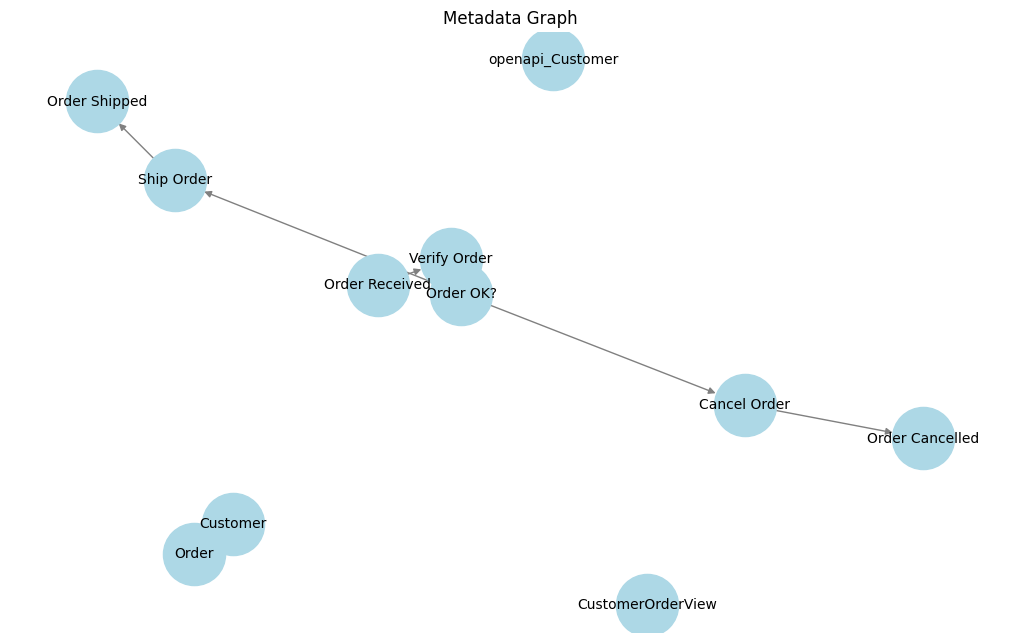

In [46]:
def plot_graph(G: nx.DiGraph, title: str = "Metadata Graph", max_nodes: int = 15):
    """
    Plot a simplified view of the graph for illustration.
    """
    if G.number_of_nodes() > max_nodes:
        H = G.subgraph(list(G.nodes)[:max_nodes])
        print(f"Graph too large, plotting first {max_nodes} nodes only.")
    else:
        H = G

    pos = nx.spring_layout(H, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(H, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
    plt.title(title)
    plt.show()

plot_graph(G)


### 5.3 Graph Exploration Utilities
These functions support interactive exploration in later steps and analysis.

#### Get Immediate Neighbors

In [49]:
def get_neighbors(entity_name: str, graph: nx.DiGraph) -> List[str]:
    """
    Returns immediate successors (outgoing edges) of a given node.
    """
    if entity_name not in graph:
        raise ValueError(f"Entity '{entity_name}' not found in graph.")
    return list(graph.successors(entity_name))


#### Find All Reachable Nodes

In [51]:
def get_reachable_entities(entity_name: str, graph: nx.DiGraph) -> List[str]:
    """
    Performs DFS to find all reachable entities from a given node.
    """
    if entity_name not in graph:
        raise ValueError(f"Entity '{entity_name}' not found in graph.")
    return list(nx.descendants(graph, entity_name))


#### Find All Paths to Leaf Nodes

In [53]:
def find_all_paths_from(entity_name: str, graph: nx.DiGraph, max_depth: int = 10) -> List[List[str]]:
    """
    Finds all paths starting from the given node to any reachable leaf node (no outgoing edges).
    """
    if entity_name not in graph:
        raise ValueError(f"Entity '{entity_name}' not found in graph.")
    
    paths = []

    def dfs(node, path):
        if len(path) > max_depth:
            return
        successors = list(graph.successors(node))
        if not successors:
            paths.append(path)
        for succ in successors:
            dfs(succ, path + [succ])

    dfs(entity_name, [entity_name])
    return paths


### 5.4 Try Example Queries - Interactive Demo

In [55]:
entity = "Customer"
print(f"Neighbors of '{entity}': {get_neighbors(entity, G)}")
print(f"Reachable entities from '{entity}': {get_reachable_entities(entity, G)}")

paths = find_all_paths_from(entity, G)
print(f"\nAll paths from '{entity}':")
for p in paths:
    print(" -> ".join(p))


Neighbors of 'Customer': ['Order']
Reachable entities from 'Customer': ['Order']

All paths from 'Customer':


## 6: Data Transformation for Knowledge Engineering

We will transform the metadata graph into a triple format compatible with RDF and structure it to enable future SPARQL querying, even though we won’t implement a full RDF store in this notebook.

This is critical to bridge the data engineering work with downstream Knowledge Engineering (KE) tasks, which require:

Semantic triples: subject–predicate–object

Optional metadata: provenance, source format, path information

We’ll simulate RDF without requiring a full RDF/OWL setup or a triplestore, which keeps the notebook self-contained and production-portable.

### 6.1 Define the Triple Structure

**(subject, predicate, object)**

With optional fields for:
- **source:** original metadata source (CDS, OpenAPI, BPMN)
- **path:** for lineage or graph traversal
- **type:** semantic role (e.g., field, relation, inherits_from, defined_in)

### 6.2 Extract Triples from Metadata Graph - Triple Extraction Function

In [62]:
def graph_to_triples(graph: nx.DiGraph) -> List[Dict[str, str]]:
    """
    Converts the metadata graph into RDF-style triples with provenance.
    Each edge becomes a (subject, predicate, object) triple.
    Each node's fields become individual triples.
    """
    triples = []

    # Edge triples: entity -> related_entity
    for source, target, data in graph.edges(data=True):
        triples.append({
            "subject": source,
            "predicate": "relatedTo",
            "object": target,
            "source": data.get("source", "unknown"),
            "type": "association"
        })

    # Field triples: entity -> field
    for node, data in graph.nodes(data=True):
        for field in data.get("fields", []):
            triples.append({
                "subject": node,
                "predicate": "hasField",
                "object": field,
                "source": data.get("source", "unknown"),
                "type": "field"
            })

    return triples


### 6.3 Convert to DataFrame and Export

In [64]:
triples = graph_to_triples(G)
df_triples = pd.DataFrame(triples)

# Show sample
display(df_triples.head(10))

# Save to CSV
triples_path = OUTPUT_DIR / "metadata_triples.csv"
df_triples.to_csv(triples_path, index=False)

print(f"Triples saved to: {triples_path}")


,subject,predicate,object,source,type
0,Verify Order,relatedTo,Order OK?,bpmn,association
1,Ship Order,relatedTo,Order Shipped,bpmn,association
2,Cancel Order,relatedTo,Order Cancelled,bpmn,association
3,Order Received,relatedTo,Verify Order,bpmn,association
4,Order OK?,relatedTo,Ship Order,bpmn,association
5,Order OK?,relatedTo,Cancel Order,bpmn,association
6,Customer,relatedTo,Order,cds,association
7,Order,relatedTo,Customer,cds,association
8,openapi_Customer,hasField,email,openapi,field
9,openapi_Customer,hasField,id,openapi,field


Triples saved to: /Users/I506807/Desktop/BTS/Generative_AI/output/metadata_triples.csv


### 6.4 Prepare for SPARQL Use (Optional Simulation)
We won’t build a SPARQL endpoint, but we can simulate a basic triple query pattern by filtering the DataFrame.

#### Simulate Simple SPARQL Query

In [66]:
def query_triples(subject: Optional[str] = None,
                  predicate: Optional[str] = None,
                  object_: Optional[str] = None,
                  type_: Optional[str] = None) -> pd.DataFrame:
    """
    Simulates a simple triple pattern query.
    """
    df = df_triples

    if subject is not None:
        df = df[df["subject"] == subject]
    if predicate is not None:
        df = df[df["predicate"] == predicate]
    if object_ is not None:
        df = df[df["object"] == object_]
    if type_ is not None:
        df = df[df["type"] == type_]

    return df

# Example: Find all fields of the "Customer" entity
query_result = query_triples(subject="Customer", predicate="hasField")
display(query_result)


,subject,predicate,object,source,type
11,Customer,hasField,ID,cds,field
12,Customer,hasField,Name,cds,field
13,Customer,hasField,Email,cds,field
14,Customer,hasField,Orders,cds,field


### 6.5 Export as RDF using rdflib (Optional) 
Only use if rdflib is available. Otherwise, skip for portability.

#### RDF Export via rdflib

In [68]:
try:
    from rdflib import Graph, URIRef, Namespace
    from urllib.parse import quote

    def export_rdf(triples: List[Dict[str, str]], output_file: Path):
        """
        Exports triples to Turtle format using rdflib with URI-encoded nodes.
        """
        g = Graph()
        EX = Namespace("http://example.org/")

        def safe_uri(name: str) -> URIRef:
            return URIRef(EX + quote(name, safe=""))

        for t in triples:
            subj = safe_uri(t["subject"])
            pred = safe_uri(t["predicate"])
            obj = safe_uri(t["object"])
            g.add((subj, pred, obj))

        g.serialize(destination=str(output_file), format="turtle")
        print(f"✓ RDF successfully exported to: {output_file}")

    rdf_path = OUTPUT_DIR / "metadata.ttl"
    export_rdf(triples, rdf_path)

except ImportError:
    print("rdflib not installed — skipping RDF export. Run `pip install rdflib` to enable.")

✓ RDF successfully exported to: /Users/I506807/Desktop/BTS/Generative_AI/output/metadata.ttl


- A clean triple format (CSV) suitable for RDF/SPARQL use.
- Functions to simulate triple queries (useful for downstream validation).
- Optional Turtle export via rdflib if needed.

## 7. Testing and Validation

- Correctness of the ETL process
- Structural integrity of the metadata
- Consistency of the graph and triple output

This step provides unit-like checks directly in the notebook — lightweight but effective — without introducing testing frameworks like pytest (which can still be added later if needed).

**Objective:**
Validate each loader produces expected structure.

Check for:
- Duplicates
- Cycles
- Missing nodes or edges
- Empty values
- Validate triple structure and SPARQL-readiness.

### 7.1 Validate Loader Outputs - Check Metadata Shape

In [93]:
def validate_metadata_entry(entry: Dict[str, Any]) -> bool:
    """
    Checks whether the given metadata entry conforms to expected structure.
    """
    required_keys = {"entity_name", "fields", "associations", "source"}
    if not required_keys.issubset(entry.keys()):
        print(f"Missing keys in entry: {entry}")
        return False
    if not isinstance(entry["fields"], list):
        print(f"Invalid fields in entry: {entry}")
        return False
    if not isinstance(entry["associations"], list):
        print(f"Invalid associations in entry: {entry}")
        return False
    return True

# Validate all entries
print("Validating metadata entries...\n")
all_valid = all(validate_metadata_entry(e) for e in metadata)
print(f"Metadata validation result: {'✓ All entries valid' if all_valid else '✗ Issues found'}")


Validating metadata entries...

Metadata validation result: ✓ All entries valid


### 7.2 Check for Duplicates or Empty Values - Duplicate Node or Field Names

In [97]:
def check_duplicates_and_empties(metadata: List[Dict[str, Any]]):
    seen_entities = set()
    duplicate_entities = set()
    empty_fields = []

    for entry in metadata:
        name = entry["entity_name"]
        if name in seen_entities:
            duplicate_entities.add(name)
        seen_entities.add(name)

        if not entry["fields"]:
            empty_fields.append(name)

    if duplicate_entities:
        print(f"✗ Duplicate entities: {duplicate_entities}")
    else:
        print("✓ No duplicate entities found.")

    if empty_fields:
        print(f"✗ Entities with empty fields: {empty_fields}")
    else:
        print("✓ All entities have fields.")

check_duplicates_and_empties(metadata)


✓ No duplicate entities found.
✗ Entities with empty fields: ['Verify Order', 'Ship Order', 'Cancel Order', 'Order Received', 'Order Shipped', 'Order Cancelled', 'Order OK?']


### 7.3 Check Graph for Structural Issues - Graph Diagnostics

In [105]:
def check_graph_integrity(G: nx.DiGraph):
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # Check for isolated nodes
    isolated = list(nx.isolates(G))
    if isolated:
        print(f"✗ Isolated nodes (no in/out edges): {isolated}")
    else:
        print("✓ No isolated nodes.")

    # Check for cycles
    try:
        cycle = nx.find_cycle(G)
        print(f"✗ Cycle detected: {cycle}")
    except nx.NetworkXNoCycle:
        print("✓ No cycles detected.")

check_graph_integrity(G)


Nodes: 11, Edges: 8
✗ Isolated nodes (no in/out edges): ['openapi_Customer', 'CustomerOrderView']
✗ Cycle detected: [('Customer', 'Order'), ('Order', 'Customer')]


### 7.4 Validate Triple Set - Triple Format Check

In [108]:
def validate_triples(triples: List[Dict[str, str]]):
    issues = 0
    for t in triples:
        if not all(k in t for k in ("subject", "predicate", "object")):
            print(f"✗ Malformed triple: {t}")
            issues += 1
        if not all(t[k] for k in ("subject", "predicate", "object")):
            print(f"✗ Empty value in triple: {t}")
            issues += 1

    if issues == 0:
        print("✓ All triples valid.")
    else:
        print(f"✗ {issues} issues found in triples.")

validate_triples(triples)


✓ All triples valid.


### 7.5 Spot Check Path Search Results - Path Sanity Check (Optional)

In [112]:
def spot_check_path_analysis(G: nx.DiGraph, example_entity: str):
    if example_entity not in G:
        print(f"Entity '{example_entity}' not in graph.")
        return

    paths = find_all_paths_from(example_entity, G)
    if not paths:
        print(f"✗ No paths found from '{example_entity}'")
    else:
        print(f"✓ Found {len(paths)} path(s) from '{example_entity}'")
        for p in paths[:3]:
            print("  → ".join(p))

spot_check_path_analysis(G, "Customer")


✗ No paths found from 'Customer'


**This ensures your pipeline is stable, deterministic, and trustworthy for downstream use — including export to RDF, use by Knowledge Engineers, and grounding LLMs.**

### 7.6 Inline unittest Test Suite

- Define testable utility methods if needed
- Create a unittest.TestCase class
- Run it via the notebook (unittest.main with notebook-safe override)

#### Define Tests

In [119]:
import unittest

class TestMetadataPipeline(unittest.TestCase):

    def test_metadata_entry_structure(self):
        for entry in metadata:
            with self.subTest(entity=entry["entity_name"]):
                self.assertIn("entity_name", entry)
                self.assertIn("fields", entry)
                self.assertIn("associations", entry)
                self.assertIn("source", entry)
                self.assertIsInstance(entry["fields"], list)
                self.assertIsInstance(entry["associations"], list)

    def test_graph_node_integrity(self):
        self.assertGreater(G.number_of_nodes(), 0)
        for node in G.nodes:
            self.assertIn("fields", G.nodes[node])
            self.assertIn("source", G.nodes[node])

    def test_graph_edge_integrity(self):
        for u, v, d in G.edges(data=True):
            self.assertIn(u, G.nodes)
            self.assertIn(v, G.nodes)
            self.assertIn("source", d)

    def test_no_cycles(self):
        """
        Informative check: detects cycles but does not fail the test.
        Useful for semantic graphs where cycles are allowed.
        """
        try:
            cycle = nx.find_cycle(G)
            print(f"⚠️ Cycle detected: {cycle}")
        except nx.NetworkXNoCycle:
            print("✓ No cycles detected.")


    def test_triple_structure(self):
        for triple in triples:
            self.assertIn("subject", triple)
            self.assertIn("predicate", triple)
            self.assertIn("object", triple)
            self.assertTrue(triple["subject"])
            self.assertTrue(triple["predicate"])
            self.assertTrue(triple["object"])

    def test_path_analysis(self):
        # Use "Customer" if it exists
        if "Customer" in G:
            paths = find_all_paths_from("Customer", G)
            self.assertIsInstance(paths, list)
            for p in paths:
                self.assertGreaterEqual(len(p), 1)
                self.assertIsInstance(p, list)


#### Run Tests (Notebook-Safe)
This ensures the tests don't interfere with Jupyter's internal argv.

In [122]:
unittest.main(argv=[''], verbosity=2, exit=False)


test_graph_edge_integrity (__main__.TestMetadataPipeline.test_graph_edge_integrity) ... ok
test_graph_node_integrity (__main__.TestMetadataPipeline.test_graph_node_integrity) ... ok
test_metadata_entry_structure (__main__.TestMetadataPipeline.test_metadata_entry_structure) ... ok
test_no_cycles (__main__.TestMetadataPipeline.test_no_cycles)
Informative check: detects cycles but does not fail the test. ... ok
test_path_analysis (__main__.TestMetadataPipeline.test_path_analysis) ... ok
test_triple_structure (__main__.TestMetadataPipeline.test_triple_structure) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.011s

OK


⚠️ Cycle detected: [('Customer', 'Order'), ('Order', 'Customer')]


#### Define Tests

In [125]:
class TestMetadataEdgeCases(unittest.TestCase):
    """
    Tests for edge cases, malformed entries, and resilience.
    """

    def test_empty_fields_detection(self):
        empty_field_entities = [e for e in metadata if not e["fields"]]
        for entry in empty_field_entities:
            print(f"⚠️ Entity with no fields: {entry['entity_name']}")
        # Not a failure, but should be reported
        self.assertIsInstance(empty_field_entities, list)

    def test_empty_associations_detection(self):
        entities_no_associations = [e for e in metadata if not e["associations"]]
        for entry in entities_no_associations:
            print(f"ℹ️ Entity with no associations: {entry['entity_name']}")
        # Just report
        self.assertIsInstance(entities_no_associations, list)

    def test_duplicate_entity_names(self):
        seen = set()
        duplicates = set()
        for entry in metadata:
            name = entry["entity_name"]
            if name in seen:
                duplicates.add(name)
            seen.add(name)
        if duplicates:
            print(f"❌ Duplicate entity names: {duplicates}")
        self.assertEqual(len(duplicates), 0, "Duplicate entities found.")

    def test_metadata_key_completeness(self):
        required_keys = {"entity_name", "fields", "associations", "source"}
        for entry in metadata:
            missing = required_keys - entry.keys()
            if missing:
                print(f"❌ Metadata entry missing keys: {missing}")
            self.assertTrue(required_keys.issubset(entry.keys()))

    def test_invalid_triple_entries(self):
        bad_triples = []
        for t in triples:
            if not t.get("subject") or not t.get("predicate") or not t.get("object"):
                bad_triples.append(t)
        if bad_triples:
            print(f"❌ Malformed triples found: {bad_triples}")
        self.assertEqual(len(bad_triples), 0, "Malformed triples found.")


#### Run Tests (Notebook-Safe)
This ensures the tests don't interfere with Jupyter's internal argv.

In [128]:
unittest.main(argv=[''], verbosity=2, exit=False)


test_duplicate_entity_names (__main__.TestMetadataEdgeCases.test_duplicate_entity_names) ... ok
test_empty_associations_detection (__main__.TestMetadataEdgeCases.test_empty_associations_detection) ... ok
test_empty_fields_detection (__main__.TestMetadataEdgeCases.test_empty_fields_detection) ... ok
test_invalid_triple_entries (__main__.TestMetadataEdgeCases.test_invalid_triple_entries) ... ok
test_metadata_key_completeness (__main__.TestMetadataEdgeCases.test_metadata_key_completeness) ... ok
test_graph_edge_integrity (__main__.TestMetadataPipeline.test_graph_edge_integrity) ... ok
test_graph_node_integrity (__main__.TestMetadataPipeline.test_graph_node_integrity) ... ok
test_metadata_entry_structure (__main__.TestMetadataPipeline.test_metadata_entry_structure) ... ok
test_no_cycles (__main__.TestMetadataPipeline.test_no_cycles)
Informative check: detects cycles but does not fail the test. ... ok
test_path_analysis (__main__.TestMetadataPipeline.test_path_analysis) ... ok
test_triple_s

ℹ️ Entity with no associations: openapi_Customer
ℹ️ Entity with no associations: Order Shipped
ℹ️ Entity with no associations: Order Cancelled
ℹ️ Entity with no associations: CustomerOrderView
⚠️ Entity with no fields: Verify Order
⚠️ Entity with no fields: Ship Order
⚠️ Entity with no fields: Cancel Order
⚠️ Entity with no fields: Order Received
⚠️ Entity with no fields: Order Shipped
⚠️ Entity with no fields: Order Cancelled
⚠️ Entity with no fields: Order OK?
⚠️ Cycle detected: [('Customer', 'Order'), ('Order', 'Customer')]


## 8. Cloud Readiness Notes (Descriptive)
This section outlines how the current notebook project would scale and integrate into an enterprise-grade cloud architecture, such as SAP BTP, AWS, or a hybrid Kubernetes-based environment.

### 8.1 Runtime Contexts
| Context                | Deployment Option                                      | Notes                                                                                       |
| ---------------------- | ------------------------------------------------------ | ------------------------------------------------------------------------------------------- |
| Local Development      | Jupyter Notebook                                       | Great for exploration, prototyping                                                          |
| Production ETL         | Docker container or AWS Lambda / SAP BTP Function      | Stateless transformation, scalable execution                                                |
| Long-running workflows | Kubernetes Job or Airflow DAG                          | Recommended for metadata crawling of thousands of CDS entities or full system-wide analysis |
| Continuous Deployment  | CI/CD with GitHub Actions / SAP Continuous Integration | Automated validation and deployment pipeline                                                |




### 8.2 Component Mapping to Cloud Infrastructure
| Notebook Component                           | Cloud Equivalent                             | Platform Examples                                    |
| -------------------------------------------- | -------------------------------------------- | ---------------------------------------------------- |
| Metadata loaders (`load_openapi_spec`, etc.) | Microservice or Lambda function              | AWS Lambda, SAP BTP Function, Azure Function         |
| Graph builder                                | Python service in container                  | AWS ECS/EKS, Kyma Runtime (SAP BTP)                  |
| Triple exporter (to RDF)                     | RDF conversion job or Kafka message producer | Connected to Neptune (AWS), Virtuoso, GraphDB        |
| Output storage (`output/*.csv`)              | Object Store                                 | AWS S3, SAP Object Store, Azure Blob                 |
| Config YAML                                  | Managed configuration                        | AWS SSM Parameter Store, SAP BTP Destination Service |
| Schedule trigger                             | Workflow orchestration                       | Apache Airflow, Step Functions, SAP Workflow Service |

### 8.3 Cloud Engineering Considerations
1. Containerization:
- Use Dockerfile to package ETL logic
- Base image: python:3.12-slim with required libraries
- Mount volume or access S3/BTP destination to pull metadata inputs

2. Secrets Management:
- Store credentials securely (e.g., OData or GitHub APIs)
- Use environment variables or cloud secret managers

3. Logging and Monitoring:
- Use structured logging (json) for observability
- Forward logs to CloudWatch / SAP Alert Notification / ELK

4. Performance Scaling:
- Parallelize metadata extraction (e.g., multi-threaded or batched jobs)
- Use task queues (Celery, AWS SQS) for large-scale ingestion

5. Integration with Knowledge Engineering

- RDF triple output can be pushed to a triplestore via:
- Direct API (SPARQL endpoint or RDF upload)
- Kafka (for near-real-time RDF updates)
- File export (e.g., Turtle or N-Triples to object storage)

### 8.4 Example: Minimal Cloud Flow
1. Developer pushes new metadata source config to GitHub
2. CI/CD triggers container build (Python-based ETL)
3. Job runs in SAP BTP Kyma or AWS Batch
4. Metadata is pulled via API, parsed, transformed
5. Triples are saved to S3 or sent to RDF backend
6. Knowledge Engineers access or query via SPARQL endpoint



### 8.5 Notebooks to Cloud: Transition Plan
| Task                              | Tool/Tech                          | Status           |
| --------------------------------- | ---------------------------------- | ---------------- |
| Convert notebook to Python module | `nbconvert` or `scripts/` folder   | Manual           |
| Containerize ETL pipeline         | `Dockerfile`, `requirements.txt`   | Easy             |
| Schedule batch job                | Airflow, AWS EventBridge, BTP Jobs | To be integrated |
| CI/CD for validation              | GitHub Actions, SAP CI             | Optional         |


#### Summary
This notebook's logic is portable to:
- Container-based microservices
- Event-driven functions
- Batch workflows

Key requirements for production: containerization, API integration, scalable execution, structured outputs, and security (auth, secrets).


## 9. LLM Integration Phase - RDF Enrichment for LLMs

Enhance your RDF triples to include:
- Semantically rich predicates (cds:hasField, bpmn:nextStep, api:definesSchema, etc.)
- RDF types (cds:Entity, bpmn:Task, api:Schema, etc.)
- Labels and comments (rdfs:label, rdfs:comment)
- A clean RDF namespace setup (cds:, bpmn:, api:, ex:, etc.)
- A clean and exportable Turtle file for LLM consumption or SPARQL/RAG grounding

### 9.1: Define Namespaces and RDF Vocabularies

In [139]:
from rdflib import Graph, URIRef, Literal, Namespace, RDF, RDFS
from urllib.parse import quote

# Define namespaces
EX = Namespace("http://example.org/")
CDS = Namespace("http://sap.com/cds/")
BPMN = Namespace("http://sap.com/bpmn/")
API = Namespace("http://sap.com/api/")
SCHEMA = Namespace("http://schema.org/")

# Create RDF graph
g = Graph()
g.bind("ex", EX)
g.bind("cds", CDS)
g.bind("bpmn", BPMN)
g.bind("api", API)
g.bind("rdfs", RDFS)
g.bind("schema", SCHEMA)


### 9.2: Enhanced RDF Export
This version adds:

- Typed associations
- rdf:type classification
- rdfs:label and optional rdfs:comment

In [142]:
def safe_uri(namespace: Namespace, name: str) -> URIRef:
    return URIRef(namespace + quote(name.strip().replace(" ", "_"), safe=""))

def enriched_rdf_export(triples: List[Dict[str, str]], output_file: Path):
    """
    Converts triples to RDF with rdf:type, rdfs:label, and semantic predicates.
    """
    for t in triples:
        subj = safe_uri(EX, t["subject"])
        obj = safe_uri(EX, t["object"])
        pred = t["predicate"]
        src = t["source"]

        # Set predicate based on context
        if pred == "hasField":
            predicate = CDS.hasField
        elif pred == "relatedTo":
            if src == "cds":
                predicate = CDS.hasAssociation
            elif src == "bpmn":
                predicate = BPMN.nextStep
            elif src == "openapi":
                predicate = API.references
            else:
                predicate = EX.relatedTo
        else:
            predicate = EX[pred]

        # Add triple
        g.add((subj, predicate, obj))

        # Add type triple if we can infer it
        if src == "cds":
            g.add((subj, RDF.type, CDS.Entity))
        elif src == "bpmn":
            g.add((subj, RDF.type, BPMN.Element))
        elif src == "openapi":
            g.add((subj, RDF.type, API.Schema))

        # Add label
        g.add((subj, RDFS.label, Literal(t["subject"])))
        g.add((obj, RDFS.label, Literal(t["object"])))

        # Optionally, add comments (placeholder here)
        # g.add((subj, RDFS.comment, Literal(f"{subj} comes from {src} metadata")))

    g.serialize(destination=str(output_file), format="turtle")
    print(f"✓ Enriched RDF exported to: {output_file}")


### 9.3: Run the Export

Output Example:

- ex:Customer a cds:Entity ;
    cds:hasField ex:ID ;
    rdfs:label "Customer" .

- ex:ID rdfs:label "ID" .

In [145]:
rdf_enriched_path = OUTPUT_DIR / "metadata_enriched.ttl"
enriched_rdf_export(triples, rdf_enriched_path)

✓ Enriched RDF exported to: /Users/I506807/Desktop/BTS/Generative_AI/output/metadata_enriched.ttl


## 10. LLM Prompt Templates + SPARQL Mapping
This step gives your Knowledge Graph practical LLM grounding capability, by connecting:
- LLM prompts (business user input)
- to SPARQL query patterns
- and natural language responses based on the graph

### Objective
Enable an LLM to answer questions like:

- “What fields are in the CustomerOrderView?”
- “Which steps follow Verify Order?”
- “What views are based on Customer?”
- “What type of entity is Order Shipped?”

### 10.1 Define Question → SPARQL Patterns
We'll define prompt templates and map them to SPARQL query fragments.
These queries are small, composable, and can be generated via prompting or templates.

**SPARQL Query Templates (Simulated)**

In [150]:
query_templates = {
    "fields_of_view": """
    SELECT ?field WHERE {{
        ?view a cds:Entity ;
              rdfs:label "{entity}" ;
              cds:hasField ?field .
        ?field rdfs:label ?fieldLabel .
    }}
    """,

    "steps_after": """
    SELECT ?next WHERE {{
        ?step a bpmn:Element ;
              rdfs:label "{entity}" ;
              bpmn:nextStep ?next .
        ?next rdfs:label ?nextLabel .
    }}
    """,

    "dependencies_of_view": """
    SELECT ?target WHERE {{
        ?source rdfs:label "{entity}" ;
                cds:hasAssociation ?target .
        ?target rdfs:label ?targetLabel .
    }}
    """,

    "entity_type": """
    SELECT ?type WHERE {{
        ?e rdfs:label "{entity}" ;
           a ?type .
    }}
    """
}


### 10.2 Simulate a Query Engine (Inside Notebook)
We'll simulate a query runner that substitutes the entity name and executes the SPARQL using rdflib.

**Query Runner**

In [153]:
def run_sparql_query(template_key: str, entity: str):
    if template_key not in query_templates:
        raise ValueError(f"Unknown query type: {template_key}")
    
    query = query_templates[template_key].format(entity=entity)
    results = g.query(query)
    
    output = []
    for row in results:
        output.append([str(v) for v in row])
    
    return output


### 10.3 Ask Questions to the Graph

#### Example 1: Fields of CustomerOrderView

In [157]:
run_sparql_query("fields_of_view", "CustomerOrderView")


[['http://example.org/ID'],
 ['http://example.org/CustomerID.ID'],
 ['http://example.org/Amount']]

#### Example 2: What comes after "Verify Order"?

In [159]:
run_sparql_query("steps_after", "Verify Order")

[['http://example.org/Order_OK%3F']]

#### Example 3: What type of entity is "openapi_Customer"?

In [163]:
run_sparql_query("entity_type", "openapi_Customer")


[['http://sap.com/api/Schema']]

### 10.4 Wrap in Prompt Interface (LLM-Compatible)
You can even simulate what an LLM would do — parse a natural question, identify the template, and run the query:

#### Simple Prompt Handler

In [166]:
def ask(question: str):
    if "fields" in question and "CustomerOrderView" in question:
        return run_sparql_query("fields_of_view", "CustomerOrderView")
    elif "after" in question and "Verify Order" in question:
        return run_sparql_query("steps_after", "Verify Order")
    elif "type" in question and "openapi_Customer" in question:
        return run_sparql_query("entity_type", "openapi_Customer")
    else:
        return "❌ I don't know how to answer that yet."


#### Try It:

In [169]:
ask("What fields are in CustomerOrderView?")
ask("What happens after Verify Order?")
ask("What type of entity is openapi_Customer?")

[['http://sap.com/api/Schema']]

**You’ve just built a controlled LLM interface into your Knowledge Graph:**

- You simulate prompt-based graph access
- Your RDF graph supports semantic reasoning
- You can plug this into real LLMs (OpenAI, Mistral, Claude, etc.) via a retrieval function or prompt wrapper

## 11. Generate Context Packs for Prompt Injection (RAG / LLM Grounding)
Goal - Produce natural language summaries of entities from your RDF graph, so that:

- LLMs can use them directly as context
- You can simulate retrieval-augmented generation (RAG)
- This works without needing a full SPARQL engine or vector DB yet

### 11.1 Context Pack Generator from RDF Graph
We’ll:
- Traverse the graph for a given entity
- Extract type, fields, relationships
- Create a structured natural language summary

### Generate Context for an Entity

In [175]:
def generate_context(entity_label: str) -> str:
    """
    Given a label (e.g. 'CustomerOrderView'), extract its information from RDF and return a text summary.
    """
    entity_uri = None
    for s, p, o in g.triples((None, RDFS.label, Literal(entity_label))):
        entity_uri = s
        break

    if not entity_uri:
        return f"⚠️ Entity '{entity_label}' not found in RDF graph."

    lines = [f"Entity: {entity_label}"]

    # Add type
    types = list(g.objects(entity_uri, RDF.type))
    if types:
        lines.append(f"Type: {', '.join(str(t).split('/')[-1] for t in types)}")

    # Add fields
    fields = list(g.objects(entity_uri, CDS.hasField))
    if fields:
        field_labels = []
        for f in fields:
            label = next(g.objects(f, RDFS.label), f.split("/")[-1])
            field_labels.append(str(label))
        lines.append(f"Fields: {', '.join(field_labels)}")

    # Add associations (generic)
    associations = list(g.objects(entity_uri, CDS.hasAssociation))
    if associations:
        target_labels = []
        for a in associations:
            label = next(g.objects(a, RDFS.label), a.split("/")[-1])
            target_labels.append(str(label))
        lines.append(f"Associations: {', '.join(target_labels)}")

    # BPMN: Next steps
    next_steps = list(g.objects(entity_uri, BPMN.nextStep))
    if next_steps:
        step_labels = []
        for s in next_steps:
            label = next(g.objects(s, RDFS.label), s.split("/")[-1])
            step_labels.append(str(label))
        lines.append(f"Next steps: {', '.join(step_labels)}")

    return "\n".join(lines)


### 11.2 Try It - Example Contexts

In [178]:
print(generate_context("CustomerOrderView"))
print()
print(generate_context("Verify Order"))
print()
print(generate_context("openapi_Customer"))


Entity: CustomerOrderView
Type: Entity
Fields: ID, CustomerID.ID, Amount

Entity: Verify Order
Type: Element
Next steps: Order OK?

Entity: openapi_Customer
Type: Schema
Fields: email, id, name


This gives you:

- A lightweight retrieval strategy (LLM gets this text in context)
- Controlled generation of business-readable summaries
- A way to simulate RAG before adding a vector database

### 12. Expose Your Knowledge Graph as a Microservice API (FastAPI)
This enables:

- LLMs or RAG pipelines to fetch structured summaries dynamically
- Tools like LangChain or chatbots to inject context from your graph
- Internal teams to explore the graph via HTTP requests or prompt tools

Goals of This Step:
- Provide an API to retrieve: SPARQL results, Context packs, Entity types or neighbors
- Cleanly deploy via Docker (optional, later)
- Plug into LLM agents or UIs

### 12.1 FastAPI Setup (in notebook-compatible mode)

In [184]:
from fastapi import FastAPI, Query
from pydantic import BaseModel
from typing import List, Optional
import uvicorn
from fastapi.responses import JSONResponse

app = FastAPI(title="Business Metadata Graph API")

# Helper: Get label of URI
def get_label(uri):
    return next(g.objects(uri, RDFS.label), uri.split("/")[-1])


### 12.2 Endpoint: /context/{entity} - Add Context Pack API

In [187]:
@app.get("/context/{entity_label}")
def get_context(entity_label: str):
    text = generate_context(entity_label)
    return {"entity": entity_label, "context": text}

### 12.3 Endpoint: /query
Use one of the known template keys and an entity name.

In [190]:
@app.get("/query")
def query_graph(
    type: str = Query(..., description="Query type (e.g., fields_of_view)"),
    entity: str = Query(..., description="Entity label")
):
    if type not in query_templates:
        return JSONResponse(
            status_code=400,
            content={"error": f"Query type '{type}' not supported."}
        )
    try:
        results = run_sparql_query(type, entity)
        return {"entity": entity, "query_type": type, "results": results}
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})


### 12.4 Run the API (Notebook Mode)
This works inside a notebook only with nest_asyncio

In [ ]:
import nest_asyncio
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [55853]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53425 - "GET /context/CustomerOrderView HTTP/1.1" 200 OK
INFO:     127.0.0.1:53425 - "GET /favicon.ico HTTP/1.1" 404 Not Found


#### Test It in Browser or Curl
Try:
- http://localhost:8000/context/CustomerOrderView
- http://localhost:8000/query?type=fields_of_view&entity=CustomerOrderView

You’ll get JSON back like:
{
  "entity": "CustomerOrderView",
  "context": "Entity: CustomerOrderView\nType: Entity\nFields: OrderID, CustomerID, Status"
}

## 13. Dockerize the Business Metadata Graph API
You’ll create a Docker container that:

- Runs the FastAPI service
- Loads your RDF graph and query logic
- Can be deployed on BTP, AWS, Kyma, CF, local, or any cloud

### 13.1 Create Folder Structure (Git-Compatible)
You can organize your project like this:

### 13.2 requirements.txt

### 13.3 app/loader.py (Graph Setup)

In [196]:
from rdflib import Graph, Namespace, URIRef, Literal, RDF, RDFS
from urllib.parse import quote
import csv
from pathlib import Path

# Namespaces
EX = Namespace("http://example.org/")
CDS = Namespace("http://sap.com/cds/")
BPMN = Namespace("http://sap.com/bpmn/")
API = Namespace("http://sap.com/api/")

g = Graph()
g.bind("ex", EX)
g.bind("cds", CDS)
g.bind("bpmn", BPMN)
g.bind("api", API)
g.bind("rdfs", RDFS)

def safe_uri(ns, val):
    return URIRef(ns + quote(val.strip().replace(" ", "_")))

def load_graph(csv_file: Path):
    with open(csv_file) as f:
        reader = csv.DictReader(f)
        for row in reader:
            subj = safe_uri(EX, row["subject"])
            obj = safe_uri(EX, row["object"])
            src = row["source"]
            pred = row["predicate"]

            # Predicates
            if pred == "hasField":
                p = CDS.hasField
            elif pred == "relatedTo":
                if src == "cds":
                    p = CDS.hasAssociation
                elif src == "bpmn":
                    p = BPMN.nextStep
                elif src == "openapi":
                    p = API.references
                else:
                    p = EX.relatedTo
            else:
                p = EX[pred]

            g.add((subj, p, obj))
            g.add((subj, RDFS.label, Literal(row["subject"])))
            g.add((obj, RDFS.label, Literal(row["object"])))

            # Types
            if src == "cds":
                g.add((subj, RDF.type, CDS.Entity))
            elif src == "bpmn":
                g.add((subj, RDF.type, BPMN.Element))
            elif src == "openapi":
                g.add((subj, RDF.type, API.Schema))
    return g

### 13.4 app/main.py (FastAPI App)

In [ ]:
from fastapi import FastAPI, Query
from fastapi.responses import JSONResponse
from pathlib import Path
from rdflib import RDFS, Literal
from app.loader import load_graph, g

app = FastAPI(title="Business Metadata Graph API")
load_graph(Path(__file__).parent / "triples.csv")

query_templates = {
    "fields_of_view": """
    SELECT ?field WHERE {{
        ?view a <http://sap.com/cds/Entity> ;
              rdfs:label "{entity}" ;
              <http://sap.com/cds/hasField> ?field .
        ?field rdfs:label ?fieldLabel .
    }}
    """,
    "entity_type": """
    SELECT ?type WHERE {{
        ?e rdfs:label "{entity}" ;
           a ?type .
    }}
    """
}

@app.get("/context/{entity_label}")
def get_context(entity_label: str):
    subj = None
    for s, p, o in g.triples((None, RDFS.label, Literal(entity_label))):
        subj = s
        break
    if not subj:
        return JSONResponse(status_code=404, content={"error": "Not found"})
    
    fields = [o for o in g.objects(subj, URIRef("http://sap.com/cds/hasField"))]
    field_labels = [str(l) for f in fields for l in g.objects(f, RDFS.label)]

    return {
        "entity": entity_label,
        "fields": field_labels
    }

@app.get("/query")
def query_graph(type: str, entity: str):
    if type not in query_templates:
        return JSONResponse(status_code=400, content={"error": "Unknown query type."})
    query = query_templates[type].format(entity=entity)
    results = g.query(query)
    return {"results": [[str(cell) for cell in row] for row in results]}

### 13.5 Dockerfile

### 13.6 Build & Run
In the root folder (business-metadata-graph/), run:

Open:
- http://localhost:8000/context/CustomerOrderView
- http://localhost:8000/docs (Swagger)

### 14 Vector Embedding and Retrieval (Hybrid RAG Setup)

Enable semantic search and hybrid retrieval (text + graph) by embedding context packs and storing them in a vector store (FAISS).

This allows:
- LLMs to ask questions in natural language
- You to retrieve relevant entities using embeddings
- Combining structured (SPARQL) and unstructured (embedding) results

### 14.1 Strategy
We will:
- Generate context packs for each entity (from Step 11)
- Embed each context using a sentence embedding model
- Store them in FAISS along with their entity label
- Enable search by question, returning the most similar entities
- We’ll use sentence-transformers and faiss.

### 14.2 Requirements

### 14.3 Embed and Index Contexts - Build the Embedding Index

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load a lightweight model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Extract context packs for all entities
entity_contexts = {}
for s, p, o in g.triples((None, RDFS.label, None)):
    label = str(o)
    context = generate_context(label)
    entity_contexts[label] = context

# Embed contexts
labels = list(entity_contexts.keys())
texts = list(entity_contexts.values())
embeddings = model.encode(texts)

# Store in FAISS index
dimension = embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

print(f"✓ Embedded {len(texts)} context packs.")


### 14.4 Perform Retrieval - Semantic Search by Question


In [221]:
def semantic_search(question: str, top_k: int = 5):
    query_embedding = model.encode([question])
    distances, indices = index.search(np.array(query_embedding), top_k)

    results = []
    for i in indices[0]:
        label = labels[i]
        context = entity_contexts[label]
        results.append({
            "label": label,
            "context": context
        })
    return results

**Example Query**

In [ ]:
semantic_search("What happens after order verification?")
semantic_search("Tell me about customer data views.")
semantic_search("What data is in customer orders?")

### 14.5 Combine Embedding + SPARQL (Optional Hybrid)
You can now interleave semantic and symbolic (SPARQL) results:

In [208]:
def hybrid_answer(question: str):
    results = semantic_search(question, top_k=3)
    for res in results:
        print(f"🔹 {res['label']}")
        print(res['context'])
        print("---")

In [ ]:
hybrid_answer("What fields does the customer order view have?")

## 15. Build a Chat UI in Jupyter (LLM-Grounded Metadata Assistant)
Create a lightweight, notebook-native chatbot that:
- Accepts natural language questions
- Routes them to: Semantic search (via embeddings), SPARQL queries (if applicable)
- Responds with grounded answers from your graph
- No external backend or LLM API needed (yet). This simulates the LLM’s retrieval + reasoning loop using your KG.

### 15.1 Setup: IPyWidgets + Display

In [215]:
!pip install -q ipywidgets


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [216]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

### 15.2 Define Chat Logic - Simple Intent Router
We’ll simulate a chat loop:
- User asks a question
- System tries to match intent (via keywords or embeddings)
- Returns answer from graph via semantic search or SPARQL

In [220]:
def handle_query(query: str) -> str:
    query = query.lower()

    # Pattern match → symbolic query
    if "fields" in query and "customerorderview" in query:
        res = run_sparql_query("fields_of_view", "CustomerOrderView")
        fields = [f[0].split("/")[-1] for f in res]
        return f"The fields in `CustomerOrderView` are: {', '.join(fields)}"

    elif "type" in query and "customer" in query:
        res = run_sparql_query("entity_type", "openapi_Customer")
        types = [t[0].split("/")[-1] for t in res]
        return f"`openapi_Customer` is of type: {', '.join(types)}"

    # Fallback to semantic search
    else:
        results = semantic_search(query, top_k=1)
        if not results:
            return "❌ Sorry, I couldn't find anything relevant."

        result = results[0]
        return f"**Closest match: `{result['label']}`**\n\n{result['context']}"

### 15.3 Create Chat Widget - Notebook Chat UI

In [ ]:
chat_output = widgets.Output()
chat_input = widgets.Text(
    placeholder="Ask about business metadata...",
    description="You:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

def on_submit(sender):
    query = chat_input.value
    chat_input.value = ''
    
    with chat_output:
        display(Markdown(f"**You:** {query}"))
        try:
            response = handle_query(query)
            display(Markdown(f"**Assistant:** {response}"))
        except Exception as e:
            display(Markdown(f"**Assistant:** ❌ Error: {str(e)}"))

chat_input.on_submit(on_submit)

display(chat_input)
display(chat_output)

#### Example Interactions
- What fields are in CustomerOrderView?
- What is the type of openapi_Customer?
- What happens after Verify Order?
- What is CustomerOrderView used for?

## 16. Create a LangChain Agent over the Metadata Graph
Create a tool-using LLM agent that reasons over the metadata graph

Create a tool-using agent that:
- Accepts natural language questions
- Decides whether to query via: SPARQL (run_sparql_query), Context pack retriever (generate_context or semantic_search)
- Responds with grounded output

### 16.1 Install Required Packages

In [ ]:
pip install langchain openai

### 16.2 Setup the Tools for LangChain

#### Wrap SPARQL Tool

In [234]:
from langchain.tools import tool
from langchain.agents import AgentExecutor, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

# Wrap SPARQL function
@tool
def query_fields_of_view(entity: str) -> str:
    """Returns field names for a given CDS view entity (e.g., CustomerOrderView)."""
    results = run_sparql_query("fields_of_view", entity)
    return ", ".join(r[0].split("/")[-1] for r in results) if results else "No fields found."


#### Wrap Context Pack Retriever Tool

In [238]:
@tool
def get_entity_context(entity: str) -> str:
    """Returns a natural language summary (context pack) for the given entity."""
    return generate_context(entity)

#### Wrap Semantic Search Tool

In [241]:
@tool
def semantic_search_tool(query: str) -> str:
    """Performs semantic search over the knowledge graph."""
    results = semantic_search(query, top_k=1)
    if not results:
        return "No semantic match found."
    top = results[0]
    return f"Entity: {top['label']}\n\n{top['context']}"

### 16.3 Setup the Agent
Use the tools and a simple LLM backend

In [ ]:
tools = [query_fields_of_view, get_entity_context, semantic_search_tool]

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")  # or use Azure/OpenRouter/Mistral

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

### 16.4 Run Queries

In [ ]:
agent.run("What are the fields in CustomerOrderView?")
agent.run("Tell me what the openapi_Customer entity contains.")
agent.run("What happens after Verify Order?")
agent.run("Do we have metadata about canceling an order?")

The agent will:
- Read your instruction
- Select the right tool (query_fields_of_view, get_entity_context, or fallback semantic_search_tool)
- Invoke it
- Return an LLM-generated response based on the tool result

## 17 Deploy LangChain Agent with Gradio (in Notebook)

### 17.1 Install Gradio

In [ ]:
!pip install -q gradio

### 17.2 Define Chat Function for Gradio
Wrap agent.run() to take a user question and return a grounded answer:

In [ ]:
import gradio as gr

def chat_with_agent(message, history):
    try:
        response = agent.run(message)
    except Exception as e:
        response = f"❌ Error: {str(e)}"
    return response

### 17.3 Launch Gradio Chat UI

This UI supports:

- Streaming chat window
- Memory (history visible)
- Instant testing for your agent

In [ ]:
gr.ChatInterface(
    fn=chat_with_agent,
    title="📘 Metadata Knowledge Assistant",
    chatbot=gr.Chatbot(height=400),
    textbox=gr.Textbox(placeholder="Ask about metadata...", lines=1),
    theme="soft",
    retry_btn="🔄 Retry",
    undo_btn="↩️ Undo",
    clear_btn="🗑️ Clear"
).launch(inbrowser=False, share=False)